In [93]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import copy
import torch.optim as optim

In [94]:
dataset_path = '../dataset'

if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print("Dataset not found. Downloading now...")
    
    %pip install --quiet kaggle
    
    os.makedirs(dataset_path, exist_ok=True)
    
    !kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification -p {dataset_path}
    
    import zipfile
    with zipfile.ZipFile(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'), 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'))
    
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Using cached version.")


Dataset already exists. Using cached version.


In [106]:
# Parameter to enable development mode
DEV = True  # Set to True for development mode (200 images), False for full dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Define directories
train_dir = '../dataset/train'
test_dir = '../dataset/test'

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

if DEV:
    # Get all labels from the dataset
    labels = np.array(full_train_dataset.targets)

    # Use NumPy to get indices for each class (Chihuahua and Muffin)
    chihuahua_indices = np.where(labels == 0)[0]  # Class 0 is Chihuahua
    muffin_indices = np.where(labels == 1)[0]     # Class 1 is Muffin

    # Shuffle the indices
    np.random.seed(0)
    np.random.shuffle(chihuahua_indices)
    np.random.shuffle(muffin_indices)

    # Select an equal number of images from each class (100 Chihuahuas, 100 Muffins)
    selected_chihuahua_indices = chihuahua_indices[:100]
    selected_muffin_indices = muffin_indices[:100]

    # Combine the selected indices and shuffle again
    selected_indices = np.concatenate([selected_chihuahua_indices, selected_muffin_indices])
    np.random.shuffle(selected_indices)

    # Split the selected indices into training (160) and validation (40)
    train_indices = selected_indices[:160]
    valid_indices = selected_indices[160:200]

    # Create subsets
    train_dataset = Subset(full_train_dataset, train_indices)
    valid_dataset = Subset(full_train_dataset, valid_indices)
    
    # Similarly, create a subset of the test dataset (first 200 images for testing)
    test_dataset = Subset(test_dataset, range(200))
    
else:
    # Split the training dataset into training and validation sets
    n_train_examples = int(len(full_train_dataset) * 0.8)
    n_valid_examples = len(full_train_dataset) - n_train_examples
    train_dataset, valid_dataset = random_split(full_train_dataset, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  # Shuffle valid data as well
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Print dataset information
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(valid_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

Number of training samples: 160
Number of validation samples: 40
Number of test samples: 200


In [107]:
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

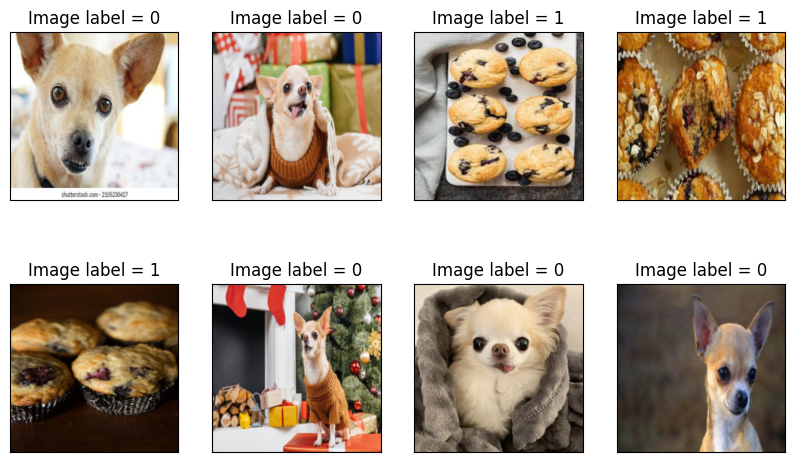

In [108]:

image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize=(10, 6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib + 1)
    
    image = image_batch_example[ib].permute(1, 2, 0).detach().numpy()

    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
    
plt.show()

In [109]:
class CNNClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_channels3=64, num_classes=2):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, num_channels1, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.flatten = nn.Flatten()

        self._initialize_input_size()
        
        self.fc1 = nn.Linear(self.input_size_linear, 128)  
        self.fc2 = nn.Linear(128, num_classes)  

    def _initialize_input_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)  
            out = self.conv_block1(dummy_input)
            out = self.conv_block2(out)
            out = self.conv_block3(out)
            self.input_size_linear = out.view(-1).size(0)

    def forward(self, x):
        out1 = self.conv_block1(x)
        out2 = self.conv_block2(out1)
        out3 = self.conv_block3(out2)
        
        out_flat = self.flatten(out3)
        
        out_fc1 = F.relu(self.fc1(out_flat))
        out_fc2 = self.fc2(out_fc1)
        
        output = F.sigmoid(out_fc2)
        
        return output

In [111]:

def eval_cnn_classifier(model, eval_dataloader):
    model.eval() 
    
    with torch.no_grad():
        correct_labels = 0
        total_labels = 0
        
        for images, labels in eval_dataloader:
            y_predicted = model(images)
            
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    return accuracy


def train_val_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True, seed=0):
    
    torch.manual_seed(seed)
    
    model_tr = copy.deepcopy(model)
    
    model_tr.train()
    
    optimizer = optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    train_losses = []
    val_accuracies = []
    
    opt_model = (copy.deepcopy(model_tr), 0)
    
    for epoch in range(num_epochs):
        tr_loss = 0
        
        for batch_index, (images, labels) in enumerate(train_dataloader):
            y_pred = model_tr.forward(images)
            
            loss = loss_fn(y_pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tr_loss += loss.item()

        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)
        
        acc_valid = eval_cnn_classifier(model_tr, valid_dataloader)
        val_accuracies.append(acc_valid)
        
        if acc_valid > opt_model[1]:
            opt_model = (copy.deepcopy(model_tr), acc_valid)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {tr_loss:.4f}, Validation Accuracy: {acc_valid:.2f}%')
    
    
    return opt_model, train_losses, val_accuracies


In [ ]:
model = CNNClassif()

print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

model.apply(init_params)

loss_fn = nn.CrossEntropyLoss()
opt_model, train_losses, val_accuracies = train_val_cnn_classifier(
    model, 
    train_dataloader, 
    valid_dataloader, 
    num_epochs=10,
    loss_fn=loss_fn, 
    learning_rate=0.01, 
    verbose=True
)

Total number of parameters:  6446498
Epoch [1/10], Training Loss: 0.8138, Validation Accuracy: 50.00%
Epoch [2/10], Training Loss: 0.8133, Validation Accuracy: 50.00%
Epoch [3/10], Training Loss: 0.8133, Validation Accuracy: 50.00%
